# Semantic Segmentation on the Indian Driving Dataset (IDD)-Mask2former

In [2]:
# 1️⃣ Confirm your Python environment
import sys
print("**Python executable:**", sys.executable)
print("**Python version:**", sys.version.split()[0])

**Python executable:** /home/steven.mascarenhas/.conda/envs/iddseg/bin/python
**Python version:** 3.10.18


In [3]:
import warnings

# Completely ignore that specific deprecation warning from torch.cuda.amp
warnings.filterwarnings(
    "ignore",
    message=r".*torch\.cuda\.amp\.autocast.*",
    category=FutureWarning,
)

# Ignore the empty-gather user warning
warnings.filterwarnings(
    "ignore",
    message=r"Was asked to gather along dimension 0.*",
    category=UserWarning,
)

# Ignore the 'Downcasting array dtype int64 to int32 to be compatible with Pillow' warning
warnings.filterwarnings(
    "ignore",
    message=r"Downcasting array dtype int64 to int32 to be compatible with 'Pillow'",
    category=UserWarning,
)


In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available! Using:", torch.cuda.get_device_name(0))
else:
    
    device = torch.device("cpu")
    print("No GPU found, using CPU.")

print("Current device:", device)

GPU is available! Using: NVIDIA A100 80GB PCIe
Current device: cuda


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("torch.cuda.device_count():", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA_VISIBLE_DEVICES: 1
torch.cuda.device_count(): 1
Current device: 0
Device name: NVIDIA A100 80GB PCIe


# IDD-Lite Semantic Segmentation: 

This notebook performs Exploratory Data Analysis (EDA) on the IDD-Lite dataset for semantic segmentation. We will:
- Explore the dataset structure and verify image/mask counts.
- Check image and mask shapes.
- List and visualize the unique class labels.
- Display example images and masks.
- Summarize class distribution.

Let's get started!


In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


## 1. Confirm Dataset Structure

We set the dataset paths and define our splits (train, val).

In [7]:
# IMG_DIR = r"D:\IDD_Segmentation_Project\dataset\idd20k_lite\leftImg8bit"
# MASK_DIR = r"D:\IDD_Segmentation_Project\dataset\idd20k_lite\gtFine"
# SPLITS = ["train", "val"]


IMG_DIR = r"dataset/idd20k_lite/leftImg8bit"
MASK_DIR = r"dataset/idd20k_lite/gtFine"
SPLITS = ["train", "val"]

## 2. Count Images and Masks per Split

We count the number of images and corresponding semantic masks available in each split (train, val) to verify the integrity and completeness of the dataset.
we dont use the test set because it doesnt have ground truth masks

In [8]:
def count_files(root, split, suffix):
    split_dir = os.path.join(root, split)
    count = 0
    if not os.path.exists(split_dir):
        return 0
    for city in os.listdir(split_dir):
        city_dir = os.path.join(split_dir, city)
        for f in os.listdir(city_dir):
            if f.endswith(suffix) and "inst" not in f:
                count += 1
    return count

for split in SPLITS:
    n_imgs = count_files(IMG_DIR, split, ".jpg")
    n_masks = count_files(MASK_DIR, split, "_label.png")
    print(f"{split.upper()}: Images = {n_imgs}, Semantic Masks = {n_masks}")


TRAIN: Images = 1403, Semantic Masks = 1403
VAL: Images = 204, Semantic Masks = 204


## 3. Check Image and Mask Shapes

We verify that all images and their masks have the expected and matching shapes (e.g., 320×227 for images, 320×227 for masks). This step ensures that the data is consistent and suitable for training a segmentation model.
 image is rgb hence 3 channels
 semantic masks is greyscale hence 1 channel

In [9]:
def check_shapes(img_dir, mask_dir, split):
    img_shapes, mask_shapes = set(), set()
    split_img = os.path.join(img_dir, split)
    split_mask = os.path.join(mask_dir, split)
    for city in os.listdir(split_img):
        city_img = os.path.join(split_img, city)
        city_mask = os.path.join(split_mask, city)
        for f in os.listdir(city_img):
            if f.endswith('.jpg'):
                img = Image.open(os.path.join(city_img, f))
                img_shape = img.size + (len(img.getbands()),)  # (width, height, channels)
                img_shapes.add(img_shape)
                mask_name = f.replace("_image.jpg", "_label.png").replace(".jpg", "_label.png")
                mask_path = os.path.join(city_mask, mask_name)
                if os.path.exists(mask_path):
                    mask = Image.open(mask_path)
                    mask_shape = mask.size + (len(mask.getbands()),)  # (width, height, channels)
                    mask_shapes.add(mask_shape)
    print(f"{split.upper()}: Unique image shapes: {img_shapes}, Unique mask shapes: {mask_shapes}")

for split in ["train", "val"]:
    check_shapes(IMG_DIR, MASK_DIR, split)


TRAIN: Unique image shapes: {(320, 227, 3)}, Unique mask shapes: {(320, 227, 1)}
VAL: Unique image shapes: {(320, 227, 3)}, Unique mask shapes: {(320, 227, 1)}


## 4. List Unique Class Labels

We extract and list the unique class IDs present in the semantic masks. This allows us to confirm the number and identity of the semantic classes in the dataset.


In [10]:
def scan_unique_ids(mask_dir, split):
    unique_ids = set()
    split_mask = os.path.join(mask_dir, split)
    for city in os.listdir(split_mask):
        city_mask = os.path.join(split_mask, city)
        for f in os.listdir(city_mask):
            if f.endswith('_label.png') and 'inst' not in f:
                arr = np.array(Image.open(os.path.join(city_mask, f)))
                unique_ids.update(np.unique(arr))
    # print(f"{split.upper()} unique IDs:", sorted(unique_ids))
    print(f"{split.upper()} unique IDs:", sorted([int(i) for i in unique_ids]))

for split in ["train", "val"]:
    scan_unique_ids(MASK_DIR, split)


TRAIN unique IDs: [0, 1, 2, 3, 4, 5, 6, 255]
VAL unique IDs: [0, 1, 2, 3, 4, 5, 6, 255]


According to the official IDD-Lite paper, there are 7 classes: we ignore 255 because its not for training

0 = Drivable  
1 = Non-drivable  
2 = Living things  
3 = Vehicles  
4 = Road side objects  
5 = Far objects  
6 = Sky  

255=ignored

In [11]:
CLASS_NAMES_1 = [
    "Drivable",
    "Non-drivable",
    "Living things",
    "Vehicles",
    "Road side objects",
    "Far objects",
    "Sky",
    "Void"   #not for training
]

### 7. Pixel-wise Class Distribution for Train and Validation Splits

To understand the data distribution across classes, we calculate the total number of pixels assigned to each semantic class in both the training and validation splits. This helps identify class imbalance issues, which can be important when training semantic segmentation models.

For each split (train and val), we plot a bar chart showing the pixel count for each class and also print the pixel counts and their percentages.

This analysis provides insights into the prevalence of each class in the dataset and helps guide model evaluation and data augmentation strategies.


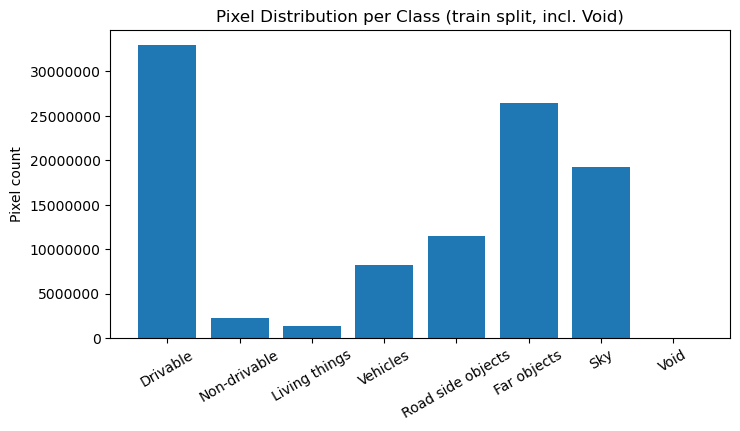

Pixel counts for 'train' split (incl. void):
Drivable: 33004689 pixels (32.38%)
Non-drivable: 2228350 pixels (2.19%)
Living things: 1330207 pixels (1.31%)
Vehicles: 8210167 pixels (8.06%)
Road side objects: 11418357 pixels (11.20%)
Far objects: 26472246 pixels (25.98%)
Sky: 19233105 pixels (18.87%)
Void: 16799 pixels (0.02%)


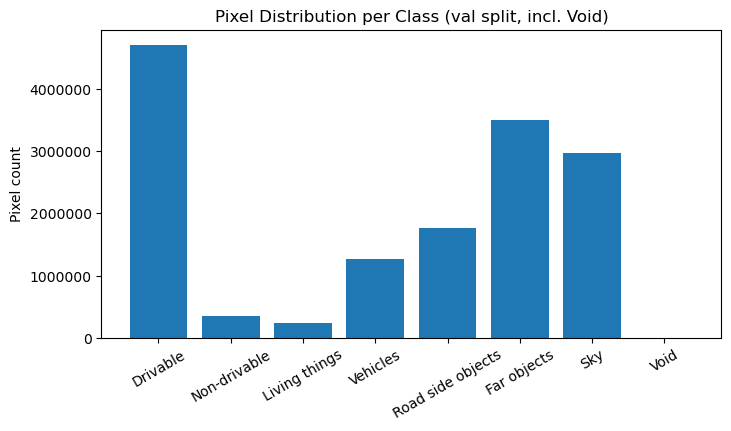

Pixel counts for 'val' split (incl. void):
Drivable: 4709943 pixels (31.78%)
Non-drivable: 355267 pixels (2.40%)
Living things: 238638 pixels (1.61%)
Vehicles: 1264972 pixels (8.54%)
Road side objects: 1769861 pixels (11.94%)
Far objects: 3502566 pixels (23.64%)
Sky: 2974262 pixels (20.07%)
Void: 3051 pixels (0.02%)


In [12]:
def plot_class_distribution(mask_dir, split, class_names):
    pixel_counts = np.zeros(len(class_names), dtype=np.int64)
    split_mask = os.path.join(mask_dir, split)
    for city in os.listdir(split_mask):
        city_mask = os.path.join(split_mask, city)
        for f in os.listdir(city_mask):
            if f.endswith('_label.png') and 'inst' not in f:
                arr = np.array(Image.open(os.path.join(city_mask, f)))
                for i in range(len(class_names)-1):  # class indices 0–6
                    pixel_counts[i] += np.sum(arr == i)
                pixel_counts[-1] += np.sum(arr == 255)  # void class
    plt.figure(figsize=(8,4))
    plt.bar(class_names, pixel_counts)
    plt.title(f"Pixel Distribution per Class ({split} split, incl. Void)")
    plt.ylabel("Pixel count")
    plt.xticks(rotation=30)
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()
    print(f"Pixel counts for '{split}' split (incl. void):")
    for name in class_names:
        i = class_names.index(name)
        print(f"{name}: {pixel_counts[i]} pixels ({pixel_counts[i]/pixel_counts.sum()*100:.2f}%)")

plot_class_distribution(MASK_DIR, "train", CLASS_NAMES_1)
plot_class_distribution(MASK_DIR, "val", CLASS_NAMES_1)

# def plot_class_distribution(mask_dir, split, class_names):
#     pixel_counts = np.zeros(len(class_names), dtype=np.int64)
#     split_mask = os.path.join(mask_dir, split)
#     for city in os.listdir(split_mask):
#         city_mask = os.path.join(split_mask, city)
#         for f in os.listdir(city_mask):
#             if f.endswith('_label.png') and 'inst' not in f:
#                 arr = np.array(Image.open(os.path.join(city_mask, f)))
#                 for i in range(len(class_names)):
#                     pixel_counts[i] += np.sum(arr == i)
#     plt.figure(figsize=(8,4))
#     plt.bar(class_names, pixel_counts)
#     plt.title(f"Pixel Distribution per Class ({split} split)")
#     plt.ylabel("Pixel count")
#     plt.xticks(rotation=30)
#     plt.ticklabel_format(style='plain', axis='y') 
#     plt.show()
#     print(f"Pixel counts for '{split}' split:")
#     for i, name in enumerate(class_names):
#         print(f"{name}: {pixel_counts[i]} pixels ({pixel_counts[i]/pixel_counts.sum()*100:.2f}%)")

# # Call for train
# plot_class_distribution(MASK_DIR, "train", CLASS_NAMES)
# # Call for val
# plot_class_distribution(MASK_DIR, "val", CLASS_NAMES)


## 5. Visualize Example Images and Masks

We randomly select a few images and display them alongside their ground-truth semantic segmentation masks. This visual inspection is a useful sanity check to ensure the masks align well with the images.


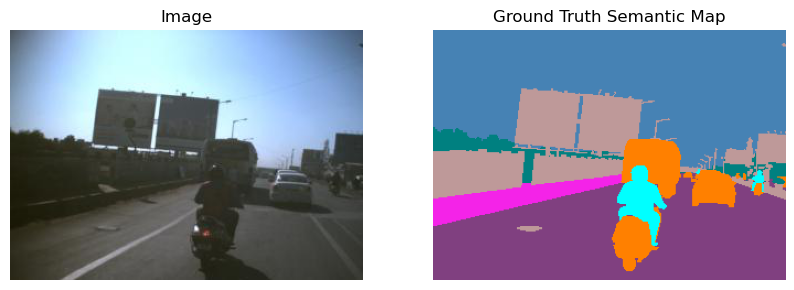

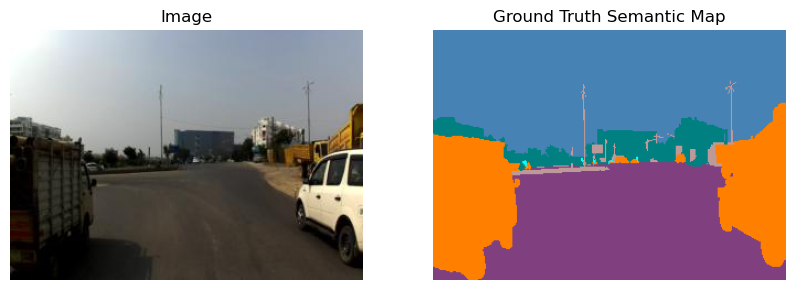

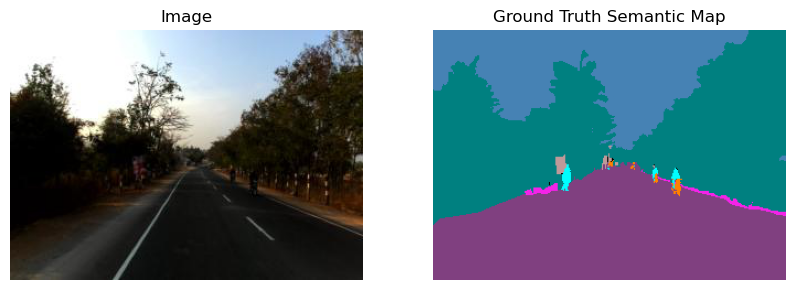

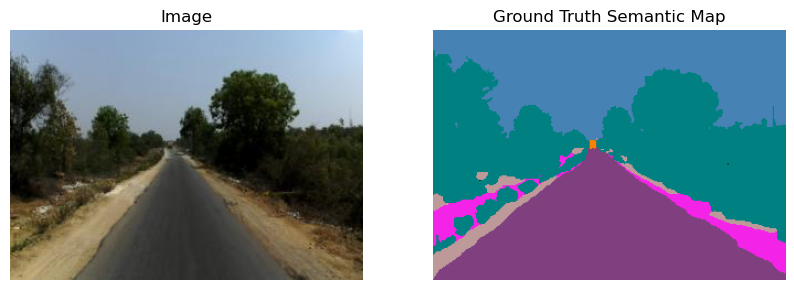

In [13]:
import random
# CLASS_COLORS = [
#     (128, 64,128),   # Drivable
#     (244, 35,232),   # Non-drivable
#     ( 70, 70, 70),   # Living things
#     (102,102,156),   # Vehicles
#     (190,153,153),   # Road side objects
#     (250,170, 30),   # Far objects
#     ( 70,130,180)    # Sky
# ]

CLASS_COLORS = [
    (128,  64,128),   # Drivable (purple)
    (244,  35,232),   # Non-drivable (pink)
    (0, 255,255),     # Living things (cyan)
    (255,128,  0),    # Vehicles (orange)
    (190,153,153),    # Road side objects (light brown)
    (0, 128,128),     # Far objects (teal)
    (70,130,180),     # Sky (sky blue)
    (0, 0, 0) ,       # Void (black)
]

CLASS_COLORS_NORM = [tuple(c/255 for c in rgb) for rgb in CLASS_COLORS]

def mask_to_rgb(mask):
    rgb = np.zeros(mask.shape + (3,), dtype=np.float32)
    for idx, color in enumerate(CLASS_COLORS_NORM):
        rgb[mask == idx] = color
    return rgb

def show_examples(img_dir, mask_dir, split, n=4):
    imgs = []
    masks = []
    split_img = os.path.join(img_dir, split)
    split_mask = os.path.join(mask_dir, split)
    for city in os.listdir(split_img):
        city_img = os.path.join(split_img, city)
        city_mask = os.path.join(split_mask, city)
        for f in os.listdir(city_img):
            if f.endswith('.jpg'):
                imgs.append(os.path.join(city_img, f))
                mask_name = f.replace("_image.jpg", "_label.png").replace(".jpg", "_label.png")
                masks.append(os.path.join(city_mask, mask_name))
    idxs = random.sample(range(len(imgs)), min(n, len(imgs)))
    for idx in idxs:
        img = np.array(Image.open(imgs[idx]))
        mask = np.array(Image.open(masks[idx]))
        mask_rgb = mask_to_rgb(mask)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(mask_rgb)
        plt.title('Ground Truth Semantic Map')
        plt.axis('off')
        plt.show()

show_examples(IMG_DIR, MASK_DIR, "train", n=4)

## 8. Check Image Resolution Distribution

We analyze the distribution of image resolutions in the dataset. Consistent image sizes are important for training deep learning models efficiently.


In [14]:
import os
from PIL import Image
from collections import Counter

# Directory where your images are stored (update as needed)
# 

IMG_DIR = r"dataset/idd20k_lite/leftImg8bit"

SPLITS = ["train", "val"]

res_counter = Counter()

for split in SPLITS:
    split_dir = os.path.join(IMG_DIR, split)
    if not os.path.exists(split_dir):
        continue
    for city in os.listdir(split_dir):
        city_dir = os.path.join(split_dir, city)
        for fname in os.listdir(city_dir):
            if fname.endswith('.jpg'):
                path = os.path.join(city_dir, fname)
                try:
                    img = Image.open(path)
                    w, h = img.size
                    res_counter[(w, h)] += 1
                except Exception as e:
                    print(f"Error reading {path}: {e}")

print("Unique image resolutions (width x height) and their counts:")
for (w, h), cnt in res_counter.items():
    print(f"{w}x{h} : {cnt} images")


Unique image resolutions (width x height) and their counts:
320x227 : 1607 images


## Training and validation process with evaluation of metrics of mask2former cityscapes pretrained with data augmentation



##  Imports

Load all necessary libraries.


In [15]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from transformers import (
    Mask2FormerImageProcessor,
    Mask2FormerForUniversalSegmentation,
    TrainingArguments,
    Trainer,
)
import evaluate


/home/steven.mascarenhas/.conda/envs/iddseg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-Processing 


# Class Names and Label Mapping
We define the 7 semantic classes used in IDD-20k Lite, and construct dictionaries to map between class indices and their string names. These are required for model configuration and evaluation.

 Map Class IDs to Names

According to the official IDD-Lite paper, there are 7 classes: we ignore 255 because its not for training

0 = Drivable  
1 = Non-drivable  
2 = Living things  
3 = Vehicles  
4 = Road side objects  
5 = Far objects  
6 = Sky  

255=ignored

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) your dataset roots
IMG_ROOT = "dataset/idd20k_lite/leftImg8bit"
MSK_ROOT = "dataset/idd20k_lite/gtFine"

# 3) classes + mappings
CLASS_NAMES = [
    "Drivable", "Non-drivable", "Living things",
    "Vehicles", "Road side objects", "Far objects", "Sky",
]
NUM_CLASSES = len(CLASS_NAMES)
IGNORE_INDEX = 255
ID2LABEL = {i: n for i, n in enumerate(CLASS_NAMES)}
LABEL2ID = {n: i for i, n in enumerate(CLASS_NAMES)}



##  Collect Image & Mask Paths

Traverse folder structure to list `.jpg` and matching `_label.png` files.


In [17]:
def get_paths(root_img, root_mask, split):
    imgs, msks = [], []
    base_i = os.path.join(root_img, split)
    base_m = os.path.join(root_mask, split)
    for city in os.listdir(base_i):
        for fn in os.listdir(os.path.join(base_i, city)):
            if fn.endswith(".jpg"):
                imgs.append(os.path.join(base_i, city, fn))
                msks.append(
                    os.path.join(
                        base_m,
                        city,
                        fn.replace("_image.jpg", "_label.png")
                    )
                )
    return imgs, msks

train_imgs, train_msks = get_paths(IMG_ROOT, MSK_ROOT, "train")
val_imgs,   val_msks   = get_paths(IMG_ROOT, MSK_ROOT, "val")




##  Augmentations (Albumentations)

Define train & validation transforms.


In [18]:
import albumentations as A

# # Training augmentations: geometric, photometric
# train_tfms = A.Compose([
#     A.Resize(512, 512),                             # Geometric: resize all images
#     A.HorizontalFlip(p=0.5),                        # Geometric: flip images left-right
#     A.ColorJitter(
#         brightness=0.1, 
#         contrast=0.1, 
#         saturation=0.1, 
#         hue=0.02, 
#         p=0.1),                                     # Photometric: vary lighting and colors
#     A.GaussianBlur(p=0.2),                          # Robustness: simulate camera blur
# ], additional_targets={"mask": "mask"})

# train_transforms = A.Compose([
#     A.RandomResizedCrop(size=(512, 512), scale=(0.7, 1.0), p=1.0),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.3),
#     A.HueSaturationValue(p=0.3),
#     A.GaussianBlur(p=0.2),
#     # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

train_tfms = A.Compose([
    A.RandomResizedCrop(size=(512, 512), scale=(0.7, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.GaussianBlur(p=0.2),
    # A.CoarseDropout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),  # Optional
], additional_targets={"mask": "mask"})

# Validation transforms: only resize for fair evaluation
val_tfms = A.Compose([
    A.Resize(512, 512),
], additional_targets={"mask": "mask"})





## Setting Mask2former Image Processor

In [19]:

from transformers import Mask2FormerImageProcessor

processor = Mask2FormerImageProcessor(
    num_labels=7,
    do_reduce_labels=False,
    do_rescale=True,
    do_normalize=True,
    ignore_index=255            # make sure this matches your dataset
)



# Custom PyTorch Dataset for IDD-k Lite
We define a PyTorch Dataset that loads images and masks, applies preprocessing, and ensures all invalid mask values are mapped to 255 (ignore index).

## 7. Custom Dataset Class

Loads, augments, processes, and returns pixel-values + labels.


In [20]:
class IDDSegDataset(Dataset):
    def __init__(self, img_paths, mask_paths, tfms, proc):
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.tfms       = tfms
        self.proc       = proc

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, i):
        img  = np.array(Image.open(self.img_paths[i]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[i]), dtype=np.int64)
        mask = np.where((mask < 0)|(mask >= NUM_CLASSES), IGNORE_INDEX, mask)

        if self.tfms:
            out = self.tfms(image=img, mask=mask)
            img, mask = out["image"], out["mask"]

        bf = self.proc(
            images=[img],
            segmentation_maps=[mask],
            return_tensors="pt"
        )
        return {
            "pixel_values": bf["pixel_values"].squeeze(0),
            "mask_labels":  bf["mask_labels"][0],
            "class_labels": bf["class_labels"][0],
            "labels":       torch.from_numpy(mask).long(),
        }

train_ds = IDDSegDataset(train_imgs, train_msks, train_tfms, processor)
val_ds   = IDDSegDataset(val_imgs,   val_msks,   val_tfms,   processor)





## 8. Collate Function

Batch and stack tensors, keep label lists.


In [21]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "mask_labels":  [b["mask_labels"]  for b in batch],
        "class_labels": [b["class_labels"] for b in batch],
        "labels":       torch.stack([b["labels"]  for b in batch]),
    }


# Model Initialization mask2former trained from scratch no pretrained weights with data augmentation
We initialize SegFormer (or Mask2Former) with ImageNet pretrained encoder weights, and configure the segmentation head for 7 classes, ignoring 255 for loss/metrics.


In [22]:
# model = Mask2FormerForUniversalSegmentation.from_pretrained(
#     "facebook/mask2former-swin-tiny-cityscapes-semantic",
#     num_labels=7,
#     id2label=ID2LABEL,
#     label2id=LABEL2ID,
#     ignore_mismatched_sizes=True,
#     ignore_value=255,
#     use_safetensors=True,   

# )

from transformers import Mask2FormerConfig, Mask2FormerForUniversalSegmentation

config = Mask2FormerConfig.from_pretrained(
    "facebook/mask2former-swin-small-cityscapes-semantic",
    num_labels=7,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
    ignore_value=255
)

# 2️⃣ Instantiate the model **from config**, giving you random init
model = Mask2FormerForUniversalSegmentation(config)

In [23]:
print(model)

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value): Lin

# Metrics: Mean IoU, Pixel Accuracy, Per-Class IoU
We use Hugging Face's evaluate library to compute mean IoU, pixel accuracy, and per-class IoU, while ignoring 255 pixels in both training and evaluation.


In [24]:
# miou = evaluate.load("mean_iou")

# def compute_metrics(eval_pred):
#     preds, labels = eval_pred

#     # Convert both preds and labels to NumPy safely
#     np_preds = []
#     for p in preds:
#         if isinstance(p, torch.Tensor):
#             np_preds.append(p.cpu().numpy())
#         else:
#             np_preds.append(p)

#     np_labels = []
#     for l in labels:
#         if isinstance(l, torch.Tensor):
#             np_labels.append(l.cpu().numpy())
#         else:
#             np_labels.append(l)

#     raw = miou.compute(
#         predictions=np_preds,
#         references=np_labels,
#         num_labels=NUM_CLASSES,
#         ignore_index=IGNORE_INDEX,
#     )

#     out = {
#         "pixel_accuracy": raw["overall_accuracy"],
#         "mean_iou":       raw["mean_iou"],
#     }
#     for i, nm in enumerate(CLASS_NAMES):
#         out[f"{nm}_iou"] = raw["per_category_iou"][i]
#     return out

# miou = evaluate.load("mean_iou")
# def compute_metrics(eval_pred):
#     preds, labels = eval_pred

#     np_preds = []
#     for p in preds:
#         if isinstance(p, torch.Tensor):
#             np_preds.append(p.cpu().numpy())
#         else:
#             np_preds.append(p)
#     np_labels = []
#     for l in labels:
#         if isinstance(l, torch.Tensor):
#             np_labels.append(l.cpu().numpy())
#         else:
#             np_labels.append(l)
#     raw = miou.compute(
#         predictions=np_preds,
#         references=np_labels,
#         num_labels=7,
#         ignore_index=255,
#     )

#     # Grab everything you want from 'raw'
#     pixel_acc = raw["overall_accuracy"]
#     mean_iou = raw["mean_iou"]
#     mean_acc = raw.get("mean_accuracy", None)
#     per_cat_iou = raw["per_category_iou"]   # array len = num_classes
#     per_class_acc = raw.get("per_category_accuracy", None)

#     # Format per-class results as dicts (for easier logging)
#     per_class_iou = {
#         f"{CLASS_NAMES[i]}_iou": float(per_cat_iou[i])
#         for i in range(len(CLASS_NAMES))
#     }
#     per_class_accuracy = {}
#     if per_class_acc is not None:
#         per_class_accuracy = {
#             f"{CLASS_NAMES[i]}_accuracy": float(per_class_acc[i])
#             for i in range(len(CLASS_NAMES))
#         }

#     # Return all metrics
#     return {
#         "pixel_accuracy": pixel_acc,
#         "mean_accuracy": mean_acc,
#         "mean_iou": mean_iou,
#         **per_class_iou,
#         **per_class_accuracy,
#     }

# miou = evaluate.load("mean_iou")

# def compute_metrics(eval_pred):
#     preds, labels = eval_pred

#     # Convert both preds and labels to NumPy safely
#     np_preds = []
#     for p in preds:
#         if isinstance(p, torch.Tensor):
#             np_preds.append(p.cpu().numpy())
#         else:
#             np_preds.append(p)

#     np_labels = []
#     for l in labels:
#         if isinstance(l, torch.Tensor):
#             np_labels.append(l.cpu().numpy())
#         else:
#             np_labels.append(l)

#     raw = miou.compute(
#         predictions=np_preds,
#         references=np_labels,
#         num_labels=7,
#         ignore_index=255,
#     )

#     # Pull extra metrics if available
#     mean_acc = raw.get("mean_accuracy", None)
#     per_class_acc = raw.get("per_category_accuracy", None)
#     per_cat_iou = raw.get("per_category_iou", None)

#     # Prepare output dict
#     out = {
#         "pixel_accuracy": raw["overall_accuracy"],
#         "mean_accuracy": mean_acc,
#         "mean_iou": raw["mean_iou"],
#     }

#     # Per-class IoU
#     if per_cat_iou is not None:
#         for i, nm in enumerate(CLASS_NAMES):
#             out[f"{nm}_iou"] = float(per_cat_iou[i])

#     # Per-class accuracy
#     if per_class_acc is not None:
#         for i, nm in enumerate(CLASS_NAMES):
#             out[f"{nm}_accuracy"] = float(per_class_acc[i])

#     return out

import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Your class names
CLASS_NAMES = [
    "drivable",
    "non_drivable",
    "living_things",
    "vehicles",
    "road_side_objects",
    "far_objects",
    "sky",
]

miou = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # 1. Convert tensors to numpy arrays (your style)
    np_preds = []
    for p in preds:
        if isinstance(p, torch.Tensor):
            np_preds.append(p.cpu().numpy())
        else:
            np_preds.append(p)
    np_labels = []
    for l in labels:
        if isinstance(l, torch.Tensor):
            np_labels.append(l.cpu().numpy())
        else:
            np_labels.append(l)

    # 2. Compute HF metrics
    raw = miou.compute(
        predictions=np_preds,
        references=np_labels,
        num_labels=7,
        ignore_index=255,
    )

    pixel_acc   = raw["overall_accuracy"]
    mean_iou    = raw["mean_iou"]
    # mean_acc    = raw.get("mean_accuracy", None)
    per_cat_iou = raw["per_category_iou"]
    # per_cat_acc = raw.get("per_category_accuracy", None)

    # 3. Confusion Matrix (mask out ignore pixels, flatten)
    p_flat = np.concatenate([m.flatten() for m in np_preds])
    l_flat = np.concatenate([m.flatten() for m in np_labels])
    mask   = (l_flat != 255)
    p_flat = p_flat[mask]
    l_flat = l_flat[mask]
    cm = confusion_matrix(l_flat, p_flat, labels=list(range(len(CLASS_NAMES))))
    cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

    plt.figure(figsize=(6,5))
    plt.imshow(cm_norm, vmin=0, vmax=1, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar(label="Frac of true-class → predicted-class")
    ticks = np.arange(len(CLASS_NAMES))
    plt.xticks(ticks, CLASS_NAMES, rotation=45, ha="right")
    plt.yticks(ticks, CLASS_NAMES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # 4. Per-class results as dicts
    per_class_iou = {
        f"{CLASS_NAMES[i]}_iou": float(per_cat_iou[i])
        for i in range(len(CLASS_NAMES))
    }
    # per_class_acc = {}
    # if per_cat_acc is not None:
    #     per_class_acc = {
    #         f"{CLASS_NAMES[i]}_accuracy": float(per_cat_acc[i])
    #         for i in range(len(CLASS_NAMES))
    #     }

    # 5. Return everything
    return {
        "pixel_accuracy": pixel_acc,
        # "mean_accuracy": mean_acc,
        "mean_iou": mean_iou,
        **per_class_iou,
        # **per_class_acc,
    }



## 9. Custom Trainer Subclass

Handle Mask2Former’s multi-output interface and post-processing.


In [25]:
class Mask2FormerTrainer(Trainer):
    def to_device(self, data, device):
        data = super().to_device(data, device)
        data["mask_labels"]  = [m.to(device) for m in data["mask_labels"]]
        data["class_labels"] = [c.to(device) for c in data["class_labels"]]
        return data

    def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
        inputs_labels = inputs.pop("labels")
        outputs = model(
            pixel_values=inputs["pixel_values"],
            mask_labels=inputs["mask_labels"],
            class_labels=inputs["class_labels"],
        )
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        labels = inputs.pop("labels")
        with torch.no_grad():
            outputs = model(
                pixel_values=inputs["pixel_values"],
                mask_labels=inputs["mask_labels"],
                class_labels=inputs["class_labels"],
            )
        loss = outputs.loss
        preds = processor.post_process_semantic_segmentation(
            outputs,
            target_sizes=[lab.shape for lab in labels],
        )
        label_list = [lab.detach().cpu() for lab in labels]
        if prediction_loss_only:
            return (loss, None, None)
        return (loss, preds, label_list)


# Training Configuration
We configure the Trainer for up to 15 epochs, use early stopping (patience=3), and save only the best checkpoint based on validation mean IoU.

In [26]:

# training_args = TrainingArguments(

    
#     output_dir="./outputs_mask2former_idd",
#     num_train_epochs=10,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=2,
#     learning_rate=6e-5,
#     weight_decay=1e-2,
#     lr_scheduler_type="polynomial",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     save_total_limit=1,
#     load_best_model_at_end=True,
#     metric_for_best_model="mean_iou",
#     greater_is_better=True,
#     logging_steps=50,
#     fp16=True,   
#     logging_dir="./logs",                       # TensorBoard log directory
#     logging_strategy="epoch",
#     report_to=["tensorboard"],  
#     seed=42, 
#     remove_unused_columns=False,
# )

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./outputs_Mask2former/Mask2former_exp4/Mask2former_swin_tiny_trained_from_scratch_with_data_augmentation",              # Where checkpoints & outputs are saved
    logging_dir="./outputs_Mask2former/Mask2former_exp4/Mask2former_swin_tiny_trained_from_scratch_with_data_augmentation/logs",        # TensorBoard logs in output dir
    report_to=["tensorboard"],                           # Enable TensorBoard logging

    num_train_epochs=10,                                 # Number of training epochs
    per_device_train_batch_size=4,                       # Training batch size
    per_device_eval_batch_size=4,                        # Eval batch size
    optim="adamw_torch",
    learning_rate=0.00006,                                  # Learning rate (from Mask2Former paper)
    weight_decay=0.01,  
    warmup_ratio=0.1,                                                              # Weight decay for regularization
    lr_scheduler_type="polynomial",                      # Poly LR scheduler


    # logging_strategy="steps",      # log training metrics every logging_steps
    # logging_steps=50,              # ← change to how often you want train‐loss logs
    # eval_strategy="steps",         # run validation every eval_steps
    # eval_steps=200,                # ← change to how often you want val‐loss/metrics
    # save_strategy="steps",         # optionally checkpoint every save_steps
    # save_steps=200,  

    # eval_strategy="epoch",                         # Evaluate after each epoch
    # save_strategy="epoch",
    logging_strategy="epoch",    # log training metrics once at end of each epoch
    eval_strategy="epoch",       # run validation once at end of each epoch
    save_strategy="epoch",       # checkpoint once at end of each epoch
    save_total_limit=1,                                 # Save after each epoch
    # save_total_limit=10,                                  # Only keep the best checkpoint
    load_best_model_at_end=True,                         # Restore best checkpoint after training
    metric_for_best_model="mean_iou",                    # Metric to pick best checkpoint
    greater_is_better=True,                              # Higher mean IoU is better

    # logging_strategy="epoch",                            # Log metrics after each epoch
    # logging_steps=50,                                  # (optional: only if logging_strategy="steps")
   
    fp16=True,                                           # Mixed precision for faster training (if supported)
    seed=42,                                             # Reproducibility
    remove_unused_columns=False,                         # Required for custom dataset/collate
)


In [27]:
from transformers import Trainer, EarlyStoppingCallback
trainer_mask2former_swin_small_trained_from_scratch_with_data_augmentation = Mask2FormerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks= [EarlyStoppingCallback(early_stopping_patience=3)],
)



# Model Training
We train the model, with evaluation and early stopping handled automatically by the Trainer.

Epoch,Training Loss,Validation Loss,Pixel Accuracy,Mean Iou,Drivable Iou,Non Drivable Iou,Living Things Iou,Vehicles Iou,Road Side Objects Iou,Far Objects Iou,Sky Iou
1,87.343500,73.020241,0.566202,0.230177,0.488753,0.000001,0.000509,0.010345,0.038621,0.256857,0.816152
2,63.596000,57.777420,0.734686,0.368989,0.788195,0.000541,0.000000,0.254387,0.063590,0.579912,0.896297
3,55.361000,53.480549,0.642492,0.341531,0.826107,0.000034,0.000000,0.263311,0.204249,0.185318,0.911700
4,50.934100,49.437939,0.757064,0.417583,0.845134,0.093313,0.000000,0.288453,0.146320,0.633072,0.916789
5,47.102400,47.201904,0.770014,0.436764,0.854668,0.084431,0.000639,0.361003,0.202924,0.639637,0.914045
6,45.307500,45.217587,0.765708,0.437908,0.865712,0.028331,0.001371,0.404567,0.258657,0.582189,0.924530
7,43.887900,43.293362,0.790113,0.479122,0.881452,0.172557,0.045510,0.425480,0.253510,0.652615,0.922730
8,42.541500,43.022823,0.768412,0.456398,0.872282,0.205454,0.000000,0.382966,0.177909,0.630817,0.925354
9,41.561800,42.333008,0.785226,0.476771,0.887775,0.199109,0.002711,0.447569,0.250996,0.622904,0.926331
10,40.654900,41.865406,0.797438,0.490991,0.884906,0.212995,0.021115,0.475076,0.251691,0.663413,0.927741


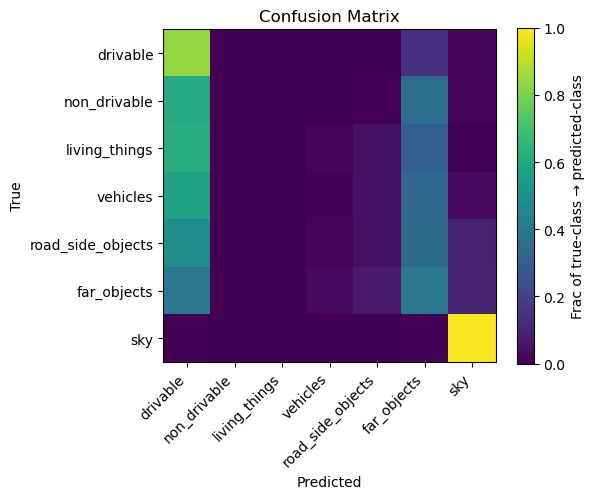

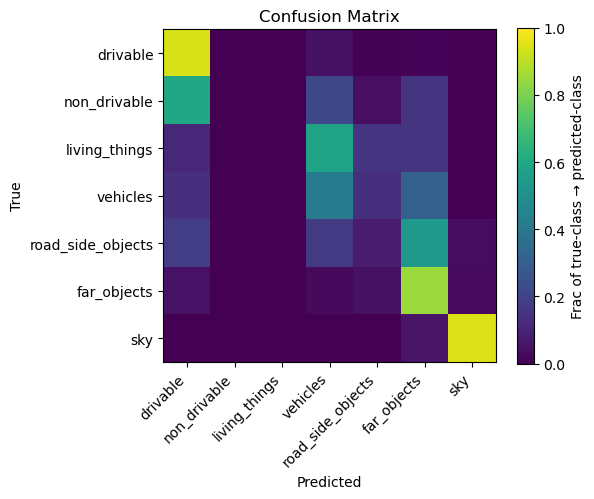

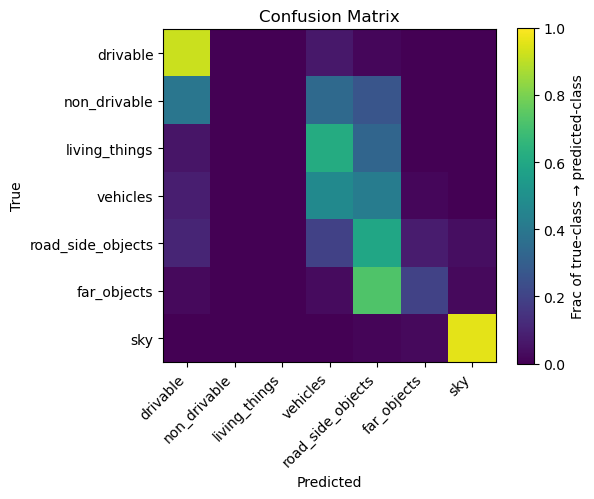

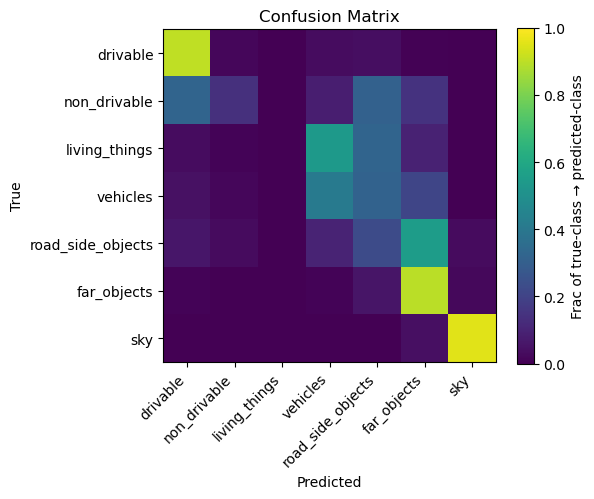

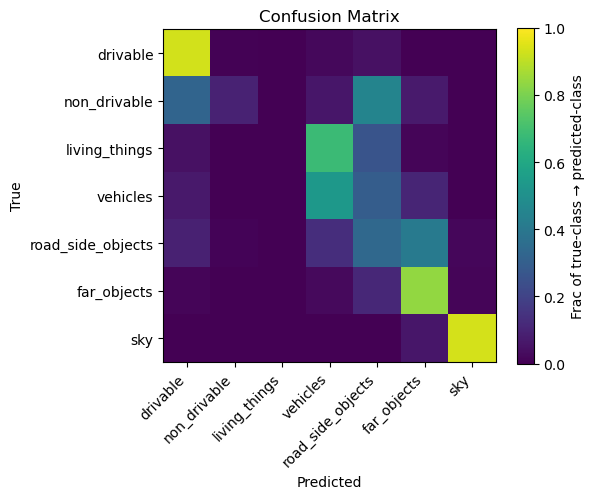

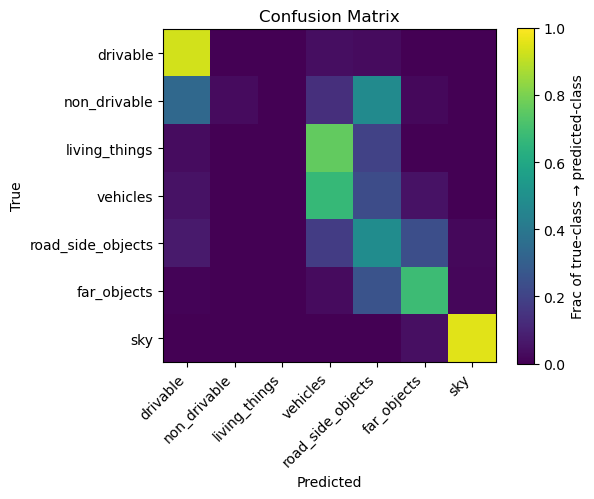

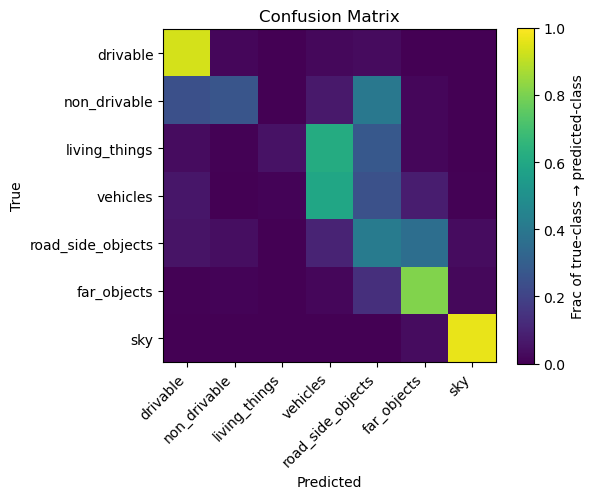

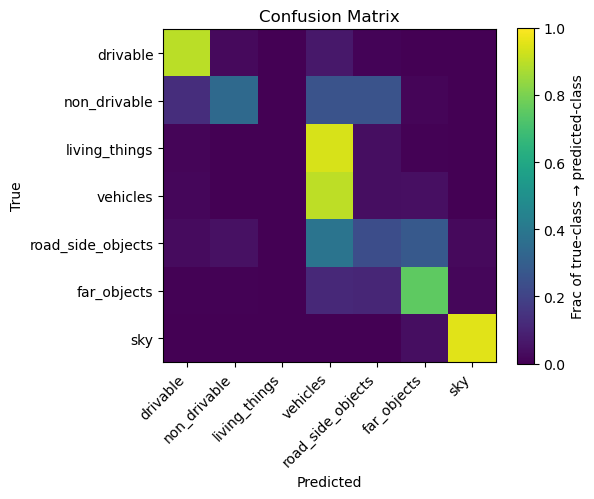

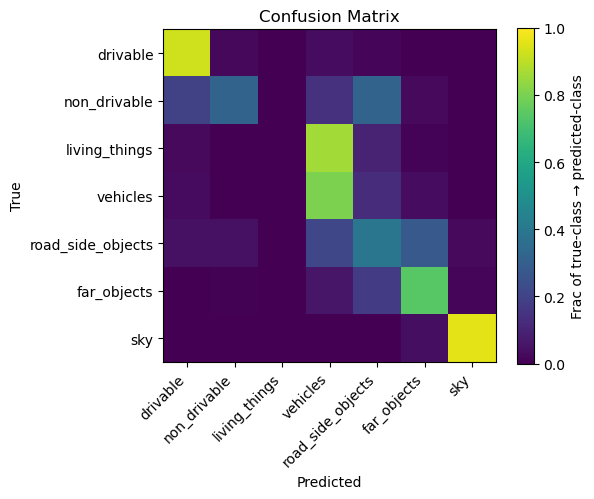

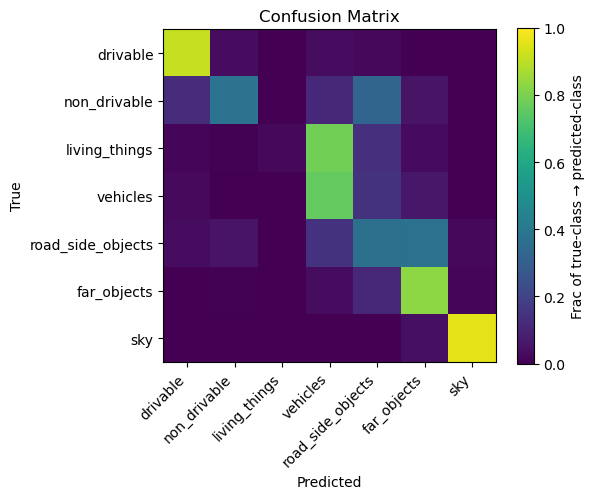

In [28]:
_ = trainer_mask2former_swin_small_trained_from_scratch_with_data_augmentation.train()

In [29]:
import pandas as pd
from IPython.display import display

# 1) Pull out the “best by mean_iou” log entry
eval_logs = [log for log in trainer_mask2former_swin_small_trained_from_scratch_with_data_augmentation.state.log_history if "eval_mean_iou" in log]
best_log  = max(eval_logs, key=lambda x: x["eval_mean_iou"])

# 2) Define the exact 22 columns in order
cols = [
    "eval_loss",
    "eval_pixel_accuracy",
    # "eval_mean_accuracy",
    "eval_mean_iou",
    "eval_drivable_iou",
    "eval_non_drivable_iou",
    "eval_living_things_iou",
    "eval_vehicles_iou",
    "eval_road_side_objects_iou",
    "eval_far_objects_iou",
    "eval_sky_iou",
    # "eval_drivable_accuracy",
    # "eval_non_drivable_accuracy",
    # "eval_living_things_accuracy",
    # "eval_vehicles_accuracy",
    # "eval_road_side_objects_accuracy",
    # "eval_far_objects_accuracy",
    # "eval_sky_accuracy",
    "eval_runtime",
    "eval_samples_per_second",
    "eval_steps_per_second",
    "epoch",
]

# 3) Build the full one‐row DataFrame
data = {k: best_log.get(k) for k in cols}
df = pd.DataFrame([data], index=["Final Metrics"])

# 4) Split into three DataFrames

# 4a) Summary: first 4 + last 4 columns
summary_cols = cols[:4] + cols[-4:]
df_summary = df[summary_cols].copy()
df_summary.index = ["Final Metrics"]

# 4b) IoU per class: columns 4–10
iou_cols = cols[4:11]
df_iou = df[iou_cols].copy()
df_iou.index = ["Final Metrics: IoU Per Class"]

# # 4c) Accuracy per class: columns 11–17
# acc_cols = cols[11:18]
# df_acc = df[acc_cols].copy()
# df_acc.index = ["Final Metrics: Accuracy Per Class"]

# 5) Ensure all columns show
pd.set_option("display.max_columns", None)



## Overall Final Metrics

In [30]:
# 6) Display the three tables
display(df_summary)




,eval_loss,eval_pixel_accuracy,eval_mean_iou,eval_drivable_iou,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Final Metrics,41.865406,0.797438,0.490991,0.884906,48.7991,4.18,1.045,10.0


## Final Metrics of IOU Per Class

In [31]:
display(df_iou)

,eval_non_drivable_iou,eval_living_things_iou,eval_vehicles_iou,eval_road_side_objects_iou,eval_far_objects_iou,eval_sky_iou,eval_runtime
Final Metrics: IoU Per Class,0.212995,0.021115,0.475076,0.251691,0.663413,0.927741,48.7991


## Final Metrics of Accuracy Per Class

In [32]:
# display(df_acc)

   epoch  train_loss  eval_loss
0    1.0     87.3435  73.020241
1    2.0     63.5960  57.777420
2    3.0     55.3610  53.480549
3    4.0     50.9341  49.437939
4    5.0     47.1024  47.201904
5    6.0     45.3075  45.217587
6    7.0     43.8879  43.293362
7    8.0     42.5415  43.022823
8    9.0     41.5618  42.333008
9   10.0     40.6549  41.865406


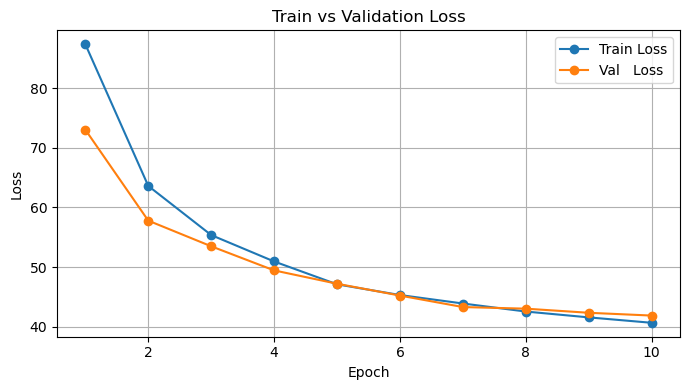

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) turn the Trainer log history into a DataFrame
logs = pd.DataFrame(trainer_mask2former_swin_small_trained_from_scratch_with_data_augmentation.state.log_history)

# 2) isolate one row per epoch where the *training* loss was logged
#    (the Trainer calls this column "loss", not "train_loss")
train_logs = (
    logs[logs["loss"].notna()]
        .drop_duplicates("epoch", keep="first")
        .loc[:, ["epoch", "loss"]]
        .rename(columns={"loss": "train_loss"})
)

# 3) isolate one row per epoch where the *validation* loss was logged
val_logs = (
    logs[logs["eval_loss"].notna()]
        .drop_duplicates("epoch", keep="first")
        .loc[:, ["epoch", "eval_loss"]]
)

# 4) merge them so we only keep epochs where *both* exist
df = pd.merge(train_logs, val_logs, on="epoch")

print(df)  # just to sanity‐check you've got both columns

# 5) plot
plt.figure(figsize=(7,4))
plt.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
plt.plot(df["epoch"], df["eval_loss"],  marker="o", label="Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Total Parameter Count of the model

In [34]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")


count_parameters(model)

Total parameters: 68,720,786
Trainable parameters: 68,720,786


## bar plot of Mean iou per epoch,pixel accuracy per epoch,mean accuracy

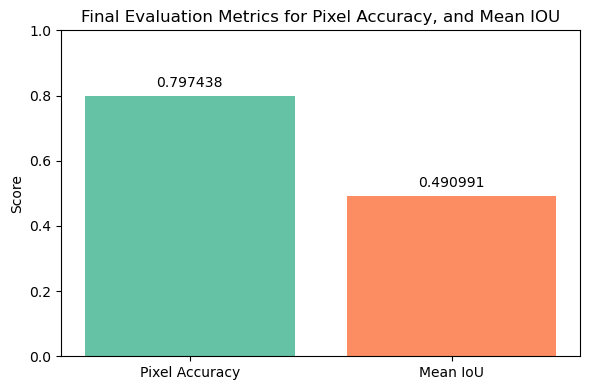

In [35]:
import matplotlib.pyplot as plt

# 1) Metrics from your best model
metrics = {
    "Pixel Accuracy": best_log["eval_pixel_accuracy"],
    # "Mean Accuracy":  best_log["eval_mean_accuracy"],
    "Mean IoU":       best_log["eval_mean_iou"],
}

names  = list(metrics.keys())
values = list(metrics.values())

# 2) Choose a distinct color for each bar
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]  # for example: mint, coral, lavender

# 3) Plot with different colors
plt.figure(figsize=(6,4))
bars = plt.bar(names, values, color=colors)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Final Evaluation Metrics for Pixel Accuracy, and Mean IOU")

# 4) Annotate each bar with its value
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.02,
       f"{h:.6f}" , # or remove the formatting for all available decimals: f"{h}"

        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


## Mean iou per epoch,pixel accuracy per epoch,mean accuracy

 epoch  Pixel Accuracy  Mean IoU
     1        0.566202  0.230177
     2        0.734686  0.368989
     3        0.642492  0.341531
     4        0.757064  0.417583
     5        0.770014  0.436764
     6        0.765708  0.437908
     7        0.790113  0.479122
     8        0.768412  0.456398
     9        0.785226  0.476771
    10        0.797438  0.490991


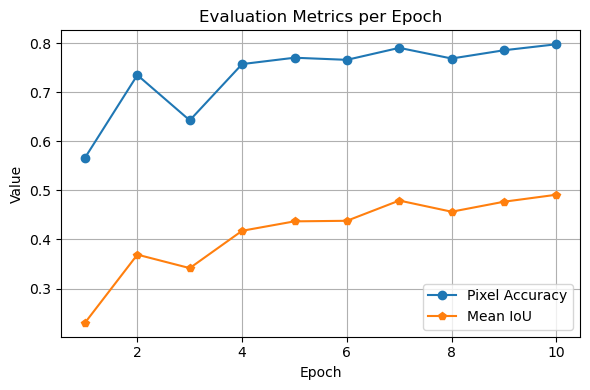

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Extract the raw log history and filter only the eval entries that contain our metrics
logs = trainer_mask2former_swin_small_trained_from_scratch_with_data_augmentation.state.log_history
eval_logs = [
    x for x in logs 
    if "eval_mean_iou" in x and "epoch" in x
]

# 2) Turn into a DataFrame
df_eval = pd.DataFrame(eval_logs)

# 3) Collapse to one value per epoch (keep the last measurement of each metric in the epoch)
metrics_per_epoch = (
    df_eval
    .groupby("epoch")[["eval_pixel_accuracy", "eval_mean_iou"]]
    .last()
    .rename(columns={
        "eval_pixel_accuracy": "Pixel Accuracy",
        # "eval_mean_accuracy":  "Mean Accuracy",
        "eval_mean_iou":       "Mean IoU",
    })
    .reset_index()
)

# 4) Cast epoch to int so it shows 1, 2, …, 10
metrics_per_epoch["epoch"] = metrics_per_epoch["epoch"].astype(int)

# 5) Print the table without the left‐hand index
print(metrics_per_epoch.to_string(index=False))

# 6) Plot all three curves on the same axes
plt.figure(figsize=(6,4))
plt.plot(metrics_per_epoch["epoch"], metrics_per_epoch["Pixel Accuracy"],
         marker="o", label="Pixel Accuracy")
# plt.plot(metrics_per_epoch["epoch"], metrics_per_epoch["Mean Accuracy"],
#          marker="s", label="Mean Accuracy")
plt.plot(metrics_per_epoch["epoch"], metrics_per_epoch["Mean IoU"],
         marker="p", label="Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Evaluation Metrics per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


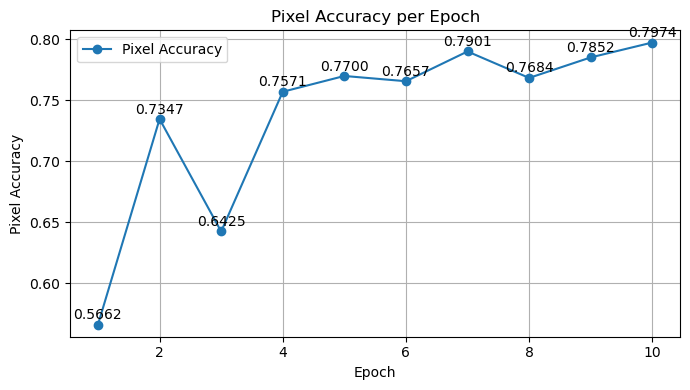

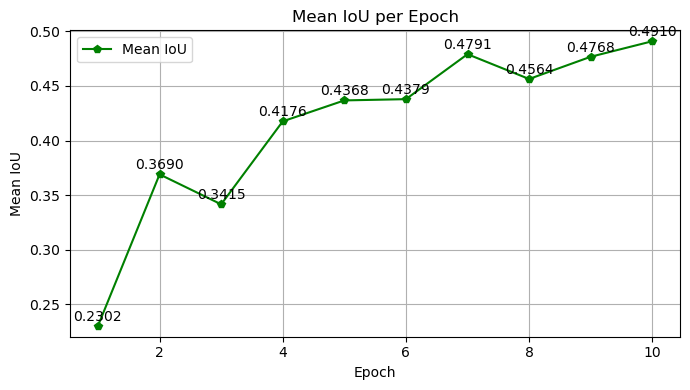

In [37]:
import matplotlib.pyplot as plt

# Pixel Accuracy plot
pixel_acc = metrics_per_epoch["Pixel Accuracy"]
plt.figure(figsize=(7, 4))
plt.plot(metrics_per_epoch["epoch"], pixel_acc, marker="o", label="Pixel Accuracy")
for x, y in zip(metrics_per_epoch["epoch"], pixel_acc):
    plt.text(x, y + 0.002, f"{y:.4f}", ha="center", va="bottom")  # 4 decimals; adjust as needed
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Pixel Accuracy per Epoch")
plt.legend()
plt.ylim(pixel_acc.min() - 0.01, pixel_acc.max() + 0.01)
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean Accuracy plot
# mean_acc = metrics_per_epoch["Mean Accuracy"]
# plt.figure(figsize=(7, 4))
# plt.plot(metrics_per_epoch["epoch"], mean_acc, marker="s", color="orange", label="Mean Accuracy")
# for x, y in zip(metrics_per_epoch["epoch"], mean_acc):
#     plt.text(x, y + 0.002, f"{y:.4f}", ha="center", va="bottom")
# plt.xlabel("Epoch")
# plt.ylabel("Mean Accuracy")
# plt.title("Mean Accuracy per Epoch")
# plt.legend()
# plt.ylim(mean_acc.min() - 0.01, mean_acc.max() + 0.01)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Mean IoU plot
mean_iou = metrics_per_epoch["Mean IoU"]
plt.figure(figsize=(7, 4))
plt.plot(metrics_per_epoch["epoch"], mean_iou, marker="p", color="green", label="Mean IoU")
for x, y in zip(metrics_per_epoch["epoch"], mean_iou):
    plt.text(x, y + 0.002, f"{y:.4f}", ha="center", va="bottom")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("Mean IoU per Epoch")
plt.legend()
plt.ylim(mean_iou.min() - 0.01, mean_iou.max() + 0.01)
plt.grid(True)
plt.tight_layout()
plt.show()


## bar plot of final iou per class

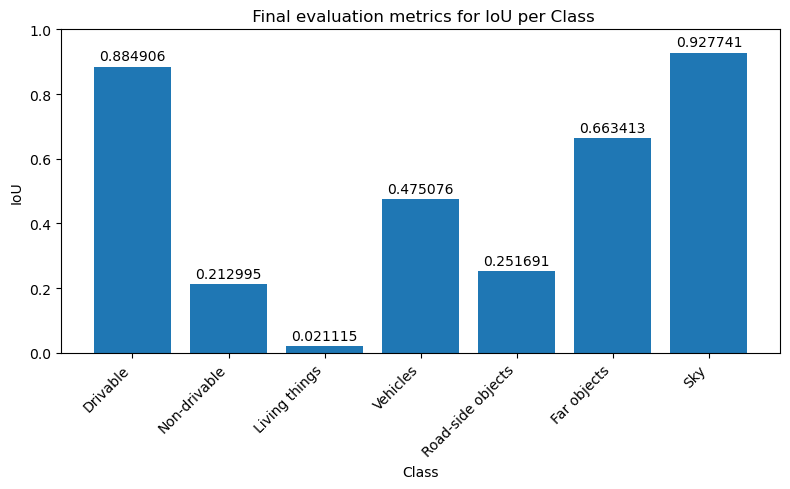

In [38]:
import matplotlib.pyplot as plt

# 1) Extract the best‐by‐mean_iou log entry
eval_logs = [l for l in trainer_mask2former_swin_small_trained_from_scratch_with_data_augmentation.state.log_history if "eval_mean_iou" in l]
best_log  = max(eval_logs, key=lambda x: x["eval_mean_iou"])

# 2) Define class names and pull IoU values from best_log
class_names = [
    "Drivable", "Non-drivable", "Living things",
    "Vehicles", "Road-side objects", "Far objects", "Sky"
]
iou_values = [
    best_log["eval_drivable_iou"],
    best_log["eval_non_drivable_iou"],
    best_log["eval_living_things_iou"],
    best_log["eval_vehicles_iou"],
    best_log["eval_road_side_objects_iou"],
    best_log["eval_far_objects_iou"],
    best_log["eval_sky_iou"],
]

# 3) Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, iou_values)
plt.xlabel("Class")
plt.ylabel("IoU")
plt.title(" Final evaluation metrics for IoU per Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha="right")

# 4) Annotate each bar with its IoU value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.6f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


# bar plot of final accuracy per class

In [39]:
# import matplotlib.pyplot as plt

# # 1) Extract the best‐by‐mean_iou log entry
# eval_logs = [l for l in trainer_mask2former_swin_tiny_trained_from_scratch_with_data_augmentation.state.log_history if "eval_mean_iou" in l]
# best_log  = max(eval_logs, key=lambda x: x["eval_mean_iou"])

# # 2) Define class names and pull Accuracy values from best_log
# class_names = [
#     "Drivable", "Non-drivable", "Living things",
#     "Vehicles", "Road-side objects", "Far objects", "Sky"
# ]
# acc_values = [
#     best_log["eval_drivable_accuracy"],
#     best_log["eval_non_drivable_accuracy"],
#     best_log["eval_living_things_accuracy"],
#     best_log["eval_vehicles_accuracy"],
#     best_log["eval_road_side_objects_accuracy"],
#     best_log["eval_far_objects_accuracy"],
#     best_log["eval_sky_accuracy"],
# ]

# # 3) Plot
# plt.figure(figsize=(8, 5))
# bars = plt.bar(class_names, acc_values)
# plt.xlabel("Class")
# plt.ylabel("Accuracy")
# plt.title("Final evaluation metrics for Accuracy per Class for Best Model")
# plt.ylim(0, 1.0)
# plt.xticks(rotation=45, ha="right")

# # 4) Annotate each bar with its Accuracy value
# for bar in bars:
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width() / 2,
#         height + 0.01,
#         f"{height:.6f}",
#         ha="center",
#         va="bottom"
#     )

# plt.tight_layout()
# plt.show()


## Visualizing Ground Truth vs Predicted Semantic Map

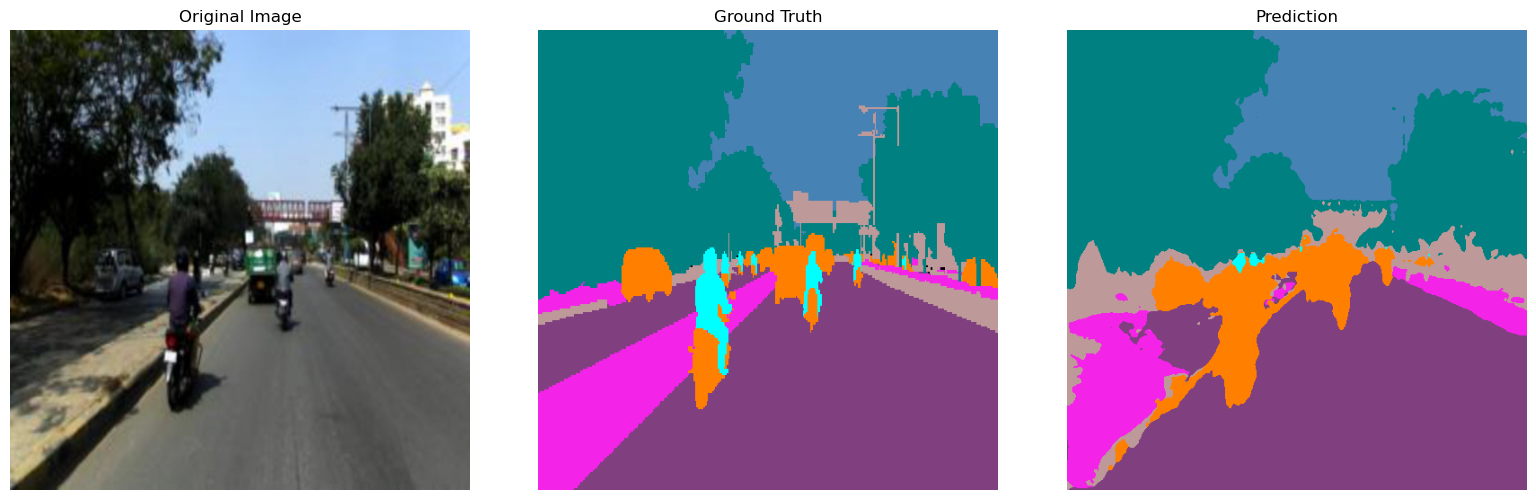

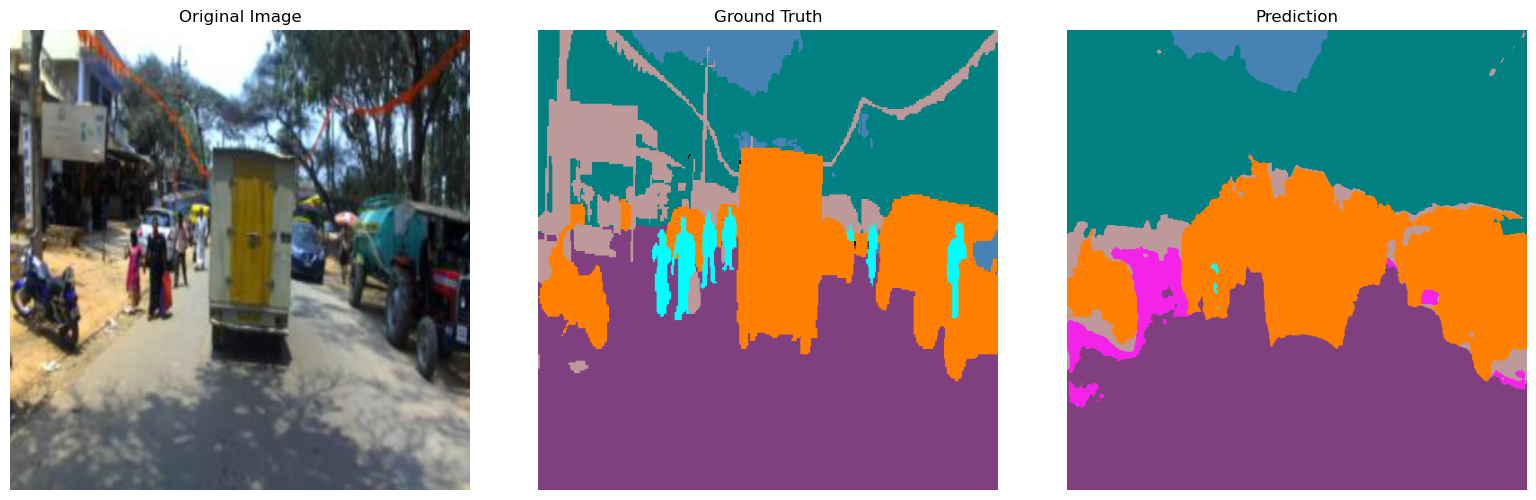

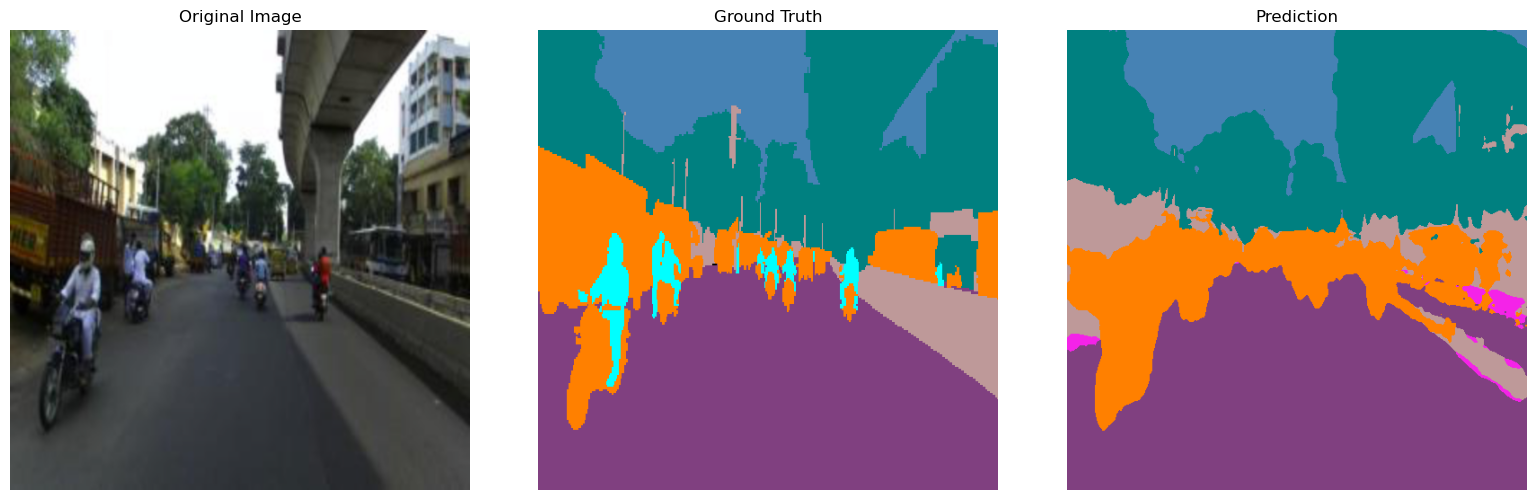

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# 1. Color palette (same as your EDA)
CLASS_COLORS = [
    (128,  64,128),   # Drivable (purple)
    (244,  35,232),   # Non-drivable (pink)
    (0, 255,255),     # Living things (cyan)
    (255,128,  0),    # Vehicles (orange)
    (190,153,153),    # Road side objects (light brown)
    (0, 128,128),     # Far objects (teal)
    (70,130,180),     # Sky (sky blue)
    (0, 0, 0) ,       # Void (black)
]

def colorize_mask(mask):
    mask_color = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id, color in enumerate(CLASS_COLORS[:-1]):
        mask_color[mask == class_id] = color
    mask_color[mask == 255] = CLASS_COLORS[-1]  # void/ignore
    return mask_color

def unnormalize_img(img):
    # img: (3, H, W), normalized
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img.permute(1,2,0).cpu().numpy()  # (H, W, 3)
    img = img * std + mean
    return np.clip(img, 0, 1)

# 2. Visualization function
def visualize_sample_vit(model, dataset, idx, processor=None, device='cuda', is_mask2former=False):
    model.eval()
    sample = dataset[idx]
    img = sample['pixel_values'].unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        if is_mask2former:
            outputs = model(pixel_values=img)
            # Use processor for post-processing (returns list of np.arrays)
            preds = processor.post_process_semantic_segmentation(
                outputs, target_sizes=[sample['labels'].shape])[0].cpu().numpy()
        else:
            logits = model(pixel_values=img).logits  # (1, num_classes, H, W)
            preds = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    gt = sample['labels'].cpu().numpy() if torch.is_tensor(sample['labels']) else sample['labels']
    orig = unnormalize_img(sample['pixel_values'])
    gt_color = colorize_mask(gt)
    pred_color = colorize_mask(preds)
    # Plot
    plt.figure(figsize=(16,5))
    plt.subplot(1,3,1); plt.imshow(orig); plt.title("Original Image"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(gt_color); plt.title("Ground Truth"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_color); plt.title("Prediction"); plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Example usage for a random batch from validation set
random_indices = random.sample(range(len(val_ds)), 3)
for idx in random_indices:
    # For SegFormer
    # visualize_sample_vit(segformer_model, val_ds, idx, processor=None, device='cuda', is_mask2former=False)
    
    # For Mask2Former
    visualize_sample_vit(model, val_ds, idx, processor=processor, device='cuda', is_mask2former=True)
